In [1]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/B1/df_clean_final.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/B1/df_clean_final.csv'

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7141485 entries, 0 to 7141484
Data columns (total 12 columns):
 #   Column              Dtype  
---  ------              -----  
 0   merchant_category   object 
 1   merchant_type       object 
 2   amount              float64
 3   currency            object 
 4   country             object 
 5   card_type           object 
 6   card_present        int64  
 7   device              object 
 8   channel             object 
 9   distance_from_home  int64  
 10  is_fraud            int64  
 11  hour                int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 653.8+ MB


In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
df_encoded = df.copy()
label_encoders = {}

for col in df_encoded.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

In [ ]:
X = df_encoded.drop(columns=['is_fraud'])
y = df_encoded['is_fraud']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
pd.Series(y_resampled).value_counts()

,count
is_fraud,
0,4704905
1,4704905


In [ ]:
import numpy as np

df['is_night'] = df['hour'].apply(lambda x: 1 if x < 6 or x >= 22 else 0)
df['is_peak_hour'] = df['hour'].apply(lambda x: 1 if 12 <= x <= 20 else 0)

def hour_bin(h):
    if 6 <= h < 12: return 'morning'
    elif 12 <= h < 17: return 'afternoon'
    elif 17 <= h < 22: return 'evening'
    else: return 'night'

df['hour_bin'] = df['hour'].apply(hour_bin)

df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

In [ ]:
# Flag large transactions — you can tweak the threshold
df['is_large_amount'] = df['amount'] > df['amount'].quantile(0.99)

# Log transform (adding 1 to avoid log(0))
df['log_amount'] = np.log1p(df['amount'])

# Z-score of amount
amount_mean = df['amount'].mean()
amount_std = df['amount'].std()
df['amount_zscore'] = (df['amount'] - amount_mean) / amount_std

In [ ]:
# Remote transaction flag
distance_threshold = df['distance_from_home'].quantile(0.95)
df['is_remote'] = df['distance_from_home'] > distance_threshold

# Card not present
df['is_card_not_present'] = 1 - df['card_present']

# Risky devices: example based on frequency — tweak as needed
risky_devices = df[df['is_fraud'] == 1]['device'].value_counts().head(10).index
df['device_risk_score'] = df['device'].apply(lambda x: 1 if x in risky_devices else 0)

# Combine channel and device
df['channel_device_combo'] = df['channel'] + "_" + df['device']

In [ ]:
df.to_csv('/content/drive/MyDrive/B1/df_final_2.csv')

Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, roc_auc_score

In [ ]:
df_model = df.copy()
label_cols = df_model.select_dtypes(include='object').columns

for col in label_cols:
    df_model[col] = LabelEncoder().fit_transform(df_model[col])

In [ ]:
X = df_model.drop(columns=['is_fraud'])
y = df_model['is_fraud']

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=37)

In [ ]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [ ]:
y_pred = lr.predict(X_test)
y_proba = lr.predict_proba(X_test)[:, 1]

In [ ]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9377    0.9791    0.9580   1176226
           1     0.8771    0.6965    0.7765    252071

    accuracy                         0.9292   1428297
   macro avg     0.9074    0.8378    0.8672   1428297
weighted avg     0.9270    0.9292    0.9259   1428297



In [ ]:
auc = roc_auc_score(y_test, y_proba)
print(f"AUC-ROC: {auc:.4f}")

AUC-ROC: 0.9596


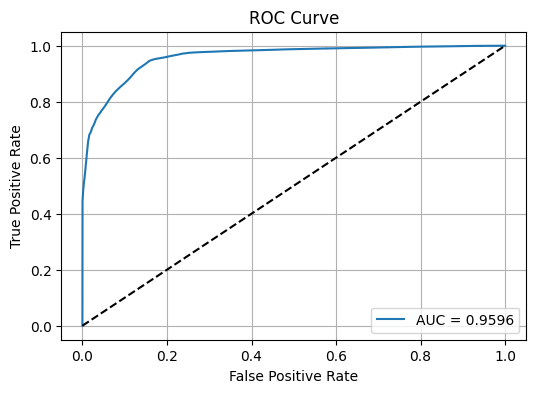

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import joblib
joblib.dump(lr, 'logistic_model.joblib')

['logistic_model.joblib']

In [ ]:
import pickle
pickle.dump(lr, open('logistic_model.pkl', 'wb'))